In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
from tensorflow.keras.callbacks import EarlyStopping as EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback
from tensorflow.keras.constraints import max_norm
from keras.utils import np_utils
import numpy as np
import random
import os
import re
import string
import glob
import sys
import io
print("GPU:", tf.test.gpu_device_name())

TensorFlow 2.x selected.
Tensorflow version: 2.0.0


Using TensorFlow backend.


GPU: /device:GPU:0


In [2]:
!git clone https://github.com/michalovsky/books_data.git

Cloning into 'books_data'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 51 (delta 10), reused 32 (delta 3), pack-reused 0
Unpacking objects: 100% (51/51), done.


In [3]:
# Read all text file paths from directory
directory1 = "books_data/kafka/"
directory2 = "books_data/shelley/"
directory3 = "books_data/defoe/"
directory4 = "books_data/plato/"

directory = directory1
file_paths = glob.glob(directory +"*.txt")    
print("Found", len(file_paths), "text files in directory:", directory)

Found 2 text files in directory: books_data/kafka/


In [4]:
# Extract text from all text files
text = ""

for file_path in file_paths:
    with open(file_path, 'r', encoding="utf-8-sig") as file:
        file_content = file.read()
        text+=file_content
print ('Length of text: {} characters'.format(len(text)))

Length of text: 573843 characters


In [5]:
# Preprocess data

punctuation_translator = str.maketrans('–—”„…«»‘’“°ſ†•✠', '               ', string.punctuation)
digits_translator = str.maketrans('', '', string.digits)
special_characters_translator = str.maketrans('ąćęłńóśźżäöüæèêéôâáà£çëîñòùúûāœï', 'acelnoszzaoueeeeoaaaeceinouuuaei', '')

# remove redundant characters and translate special characters
text = text.lower().translate(punctuation_translator).translate(digits_translator).translate(special_characters_translator)

# remove "rozdzial <number>" and "chapter <number>" strings 
text = re.sub(r"\nrozdzial\s(.*)\n", "", text)
text = re.sub(r"\nchapter\s(.*)\n", "", text)

#remove extra spaces and new lines
text = ' '.join(text.split())

print ('Length of text after preprocessing: {} characters'.format(len(text)))

Length of text after preprocessing: 548207 characters


In [6]:
# Creating a mapping from unique characters to indices
vocab = sorted(list(set(text)))
vocab_size = len(vocab)
char2idx = dict((c, i) for i, c in enumerate(vocab))
idx2char = dict((i, c) for i, c in enumerate(vocab))
print ('{} unique characters:'.format(len(vocab)))
print(vocab)

27 unique characters:
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

sequence_length = 50
step = 1
sentences = []
labels = []
encoded = np.array([char2idx[ch] for ch in text]) 

for i in range(0, len(encoded) - sequence_length, step):
    sentences.append(encoded[i:i + sequence_length])
    labels.append(encoded[i + sequence_length])

data_size = len(sentences)
print("Data size:", data_size)

X = np.reshape(sentences, (data_size, sequence_length, 1))
X = np_utils.to_categorical(X)
y = np_utils.to_categorical(labels)

# Shuffle data set
# X, y = shuffle(X, y, random_state=42)

# Split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

Data size: 548157


In [25]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, vocab_size),return_sequences=True, recurrent_initializer='glorot_uniform'))
model.add(LSTM(128, recurrent_initializer='glorot_uniform'))
model.add(Dropout(0.1))
model.add(Dense(vocab_size, activation='softmax'))

# model = Sequential()
# model.add(LSTM(256, input_shape=(sequence_length, vocab_size), return_sequences=True, recurrent_initializer='glorot_uniform', kernel_constraint=max_norm(3)))
# # recurrent_constraint=max_norm(3), bias_constraint=max_norm(3)))
# model.add(BatchNormalization())
# model.add(LSTM(256, recurrent_initializer='glorot_uniform', kernel_constraint=max_norm(3), return_sequences=True))
# model.add(BatchNormalization())
# model.add(LSTM(256, recurrent_initializer='glorot_uniform', kernel_constraint=max_norm(3)))
# model.add(BatchNormalization())
# model.add(Dense(y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 50, 128)           79872     
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 27)                3483      
Total params: 214,939
Trainable params: 214,939
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Setting callbacks

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_text(amount=100):
    start_index = random.randint(0, len(text) - sequence_length - 1)

    seed = text[start_index: start_index + sequence_length]
    print('Generating with seed: "' + seed + '"')
    
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('Diversity:', diversity)
        sentence = seed
        generated = ''
        generated += sentence
        sys.stdout.write(generated)

        for i in range(amount):
            x_pred = np.zeros((1, sequence_length, vocab_size))
            for t, char in enumerate(sentence):
                x_pred[0, t, char2idx[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = idx2char[next_index]

            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('Generating text after Epoch: %d' % epoch)
    generate_text()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=100)

# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
# checkpoint = ModelCheckpoint(filepath=checkpoint_prefix, monitor='loss', save_best_only=True, mode='min')

callbacks = [ es]

In [27]:
batch_size = 128
epochs = 100
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=2, callbacks=callbacks)

Train on 438525 samples, validate on 109632 samples
Epoch 1/100
438525/438525 - 43s - loss: 1.9134 - accuracy: 0.4285 - val_loss: 1.5536 - val_accuracy: 0.5248
Epoch 2/100
438525/438525 - 40s - loss: 1.4739 - accuracy: 0.5460 - val_loss: 1.3570 - val_accuracy: 0.5808
Epoch 3/100
438525/438525 - 39s - loss: 1.3327 - accuracy: 0.5865 - val_loss: 1.2721 - val_accuracy: 0.6060
Epoch 4/100
438525/438525 - 39s - loss: 1.2560 - accuracy: 0.6085 - val_loss: 1.2229 - val_accuracy: 0.6184
Epoch 5/100
438525/438525 - 39s - loss: 1.2065 - accuracy: 0.6223 - val_loss: 1.1925 - val_accuracy: 0.6280
Epoch 6/100
438525/438525 - 39s - loss: 1.1713 - accuracy: 0.6323 - val_loss: 1.1757 - val_accuracy: 0.6323
Epoch 7/100
438525/438525 - 39s - loss: 1.1431 - accuracy: 0.6403 - val_loss: 1.1593 - val_accuracy: 0.6377
Epoch 8/100
438525/438525 - 39s - loss: 1.1209 - accuracy: 0.6462 - val_loss: 1.1536 - val_accuracy: 0.6401
Epoch 9/100
438525/438525 - 39s - loss: 1.1019 - accuracy: 0.6524 - val_loss: 1.1436

In [0]:
tf.train.latest_checkpoint(checkpoint_dir) #second param direct file: "ckpt_50"

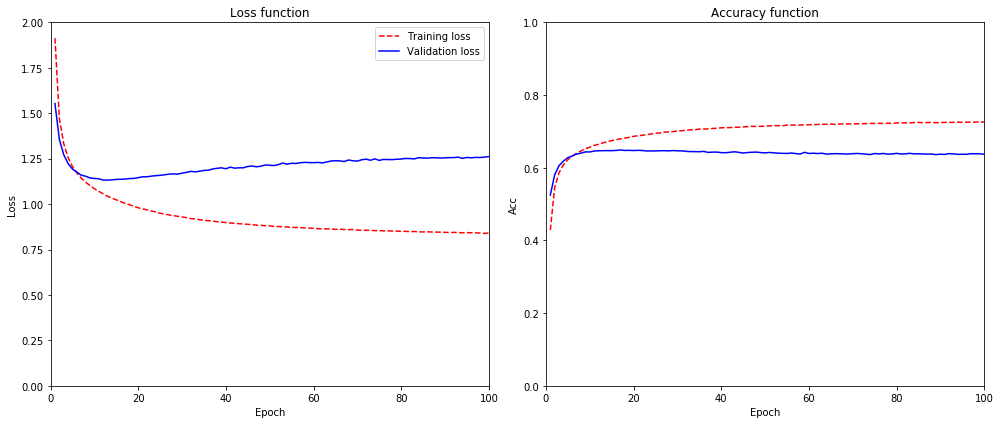

In [28]:
import matplotlib.pyplot as plt

# Make characteristics
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

f = plt.figure(figsize=(14,6))

a0 = f.add_subplot(121)
a0.plot(epoch_count, training_loss, 'r--', label="Training loss")
a0.plot(epoch_count, validation_loss, 'b-', label="Validation loss")
a0.legend()
a0.set_title("Loss function")
a0.set_xlabel("Epoch")
plt.xlim(0, epochs)
a0.set_ylabel("Loss")
plt.ylim(0, np.ceil(max(training_loss)))

a1 = f.add_subplot(122)
a1.plot(epoch_count, training_acc, 'r--', label="Training acc")
a1.plot(epoch_count, validation_acc, 'b-', label="Validation acc")
a1.set_title("Accuracy function")
a1.set_xlabel("Epoch")
plt.xlim(0, epochs)
a1.set_ylabel("Acc")
plt.ylim(0, 1)
# plt.savefig(save_directory+"/characteristics.png")  

plt.tight_layout()
plt.show()

In [29]:
generate_text(200)

----- diversity: 0.2
----- Generating with seed: "fours as you put it makes you something better tha"
fours as you put it makes you something better that he could not be seen as he said and started to speak to her and they stood at the steps and so he could see the doorkeeper said the priest and there was a serious corry of the painter said and what 
----- diversity: 0.5
----- Generating with seed: "fours as you put it makes you something better tha"
fours as you put it makes you something better than i listen now be asking he said even though he was pretending the doorkeeper had a pent of course you can see the doorkeeper gives in the first part and it was the doorkeeper with the student and har
----- diversity: 1.0
----- Generating with seed: "fours as you put it makes you something better tha"
fours as you put it makes you something better that they had to be right to block a general italian stand almost by the way he was understanding a little i ive speaking as he get to this moodo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


ven once more interested you were being provising it from ks subordination playing it was under she had only reached
